In [74]:
import numpy as np
import pandas as pd
import scanpy as sc 

adata = sc.read_h5ad("dataset_co_mo.h5ad")

In [75]:
# Data prep
sc.pp.normalize_total(adata, target_sum=1e4) # You can adjust target_sum # Seems not to help
sc.pp.log1p(adata)

In [76]:
import scanpy as sc
import pandas as pd
from sklearn.metrics import mutual_info_score
import numpy as np

def get_correlated_genes_ranked(adata, target_gene, n_bins=50, top_n=10):
    """
    Computes and returns the ranked lists of genes correlated with a target gene
    based on absolute Pearson correlation, absolute Spearman correlation,
    and Mutual Information.

    Args:
        adata: AnnData object containing the gene expression data.
        target_gene: The name of the gene to find correlations with (string).
        n_bins: The number of bins to use for discretizing gene expression
                for Mutual Information calculation (integer).
        top_n: The number of top correlated genes to display for each method (integer).

    Returns:
        A tuple containing three Pandas Series:
        - ranked_pearson_abs: Ranked absolute Pearson correlations.
        - ranked_spearman_abs: Ranked absolute Spearman correlations.
        - ranked_mi: Ranked Mutual Information scores.
    """
    if target_gene not in adata.var_names:
        print(f"Error: Gene '{target_gene}' not found in the AnnData object.")
        return None, None, None

    # Get the expression vector of the target gene
    target_gene_expression = adata[:, target_gene].X.toarray().flatten()

    # Create a Pandas DataFrame from the gene expression matrix
    expression_df = pd.DataFrame(adata.X.toarray(), columns=adata.var_names)

    # Calculate Absolute Pearson correlation
    pearson_correlations = expression_df.corrwith(pd.Series(target_gene_expression, index=expression_df.index)).abs()
    pearson_correlations = pearson_correlations.drop(target_gene, errors='ignore')
    ranked_pearson_abs = pearson_correlations.sort_values(ascending=False)

    # Calculate Absolute Spearman correlation
    spearman_correlations = expression_df.corrwith(pd.Series(target_gene_expression, index=expression_df.index), method='spearman').abs()
    spearman_correlations = spearman_correlations.drop(target_gene, errors='ignore')
    ranked_spearman_abs = spearman_correlations.sort_values(ascending=False)

    # Calculate Mutual Information
    mutual_info_scores = pd.Series(index=expression_df.columns)
    target_series = pd.Series(target_gene_expression)
    target_discretized = pd.cut(target_series, bins=n_bins, labels=False, include_lowest=True) # Define target_discretized here

    for gene in expression_df.columns:
        if gene != target_gene:
            other_discretized = pd.cut(pd.Series(expression_df[gene].values), bins=n_bins, labels=False, include_lowest=True)
            mi = mutual_info_score(target_discretized, other_discretized)
            mutual_info_scores[gene] = mi

    ranked_mi = mutual_info_scores.sort_values(ascending=False)

    #print(f"\n--- Top {top_n} Absolute Pearson Correlation with {target_gene} ---")
    #print(ranked_pearson_abs.head(top_n))

    #print(f"\n--- Top {top_n} Absolute Spearman Correlation with {target_gene} ---")
    #print(ranked_spearman_abs.head(top_n))

    #print(f"\n--- Top {top_n} Mutual Information with {target_gene} ---")
    #print(ranked_mi.head(top_n))

    return ranked_pearson_abs, ranked_spearman_abs, ranked_mi

In [77]:
# # Compute correlated genes
# ict1 = adata.obs["BatchID"] == "Cancer Cells (Co)"
# adata_co = adata[ict1, :].copy()

# # Choose the target gene you want to find correlations with
# target_gene = 'PDGFB'  # Replace with the actual gene name
# rankp, ranks, rankm = get_correlated_genes_ranked(adata_co, target_gene, n_bins=50, top_n=10)
# # ig = 'TGFBR2'
# # rankg = rankm.rank(ascending=False)[ig]
# # print(rankm[ig])
# # print(rankg)
# print(rankm[0:10])
# # Choose the target gene you want to find correlations with
# target_gene = 'TGFBR2'  # Replace with the actual gene name
# rankp, ranks, rankm2 = get_correlated_genes_ranked(adata_co, target_gene, n_bins=50, top_n=10)
# print(rankm2[0:10])

In [78]:
# # Compute correlated genes
# ict = adata.obs["BatchID"] == "Fibroblasts (Co)"
# adata_co2 = adata[ict, :].copy()

# # Choose the target gene you want to find correlations with
# target_gene = 'TGFB1'  # Replace with the actual gene name
# rankp, ranks, rankm = get_correlated_genes_ranked(adata_co, target_gene, n_bins=50, top_n=10)
# # ig = 'PDGFRB'
# # rankg = rankm.rank(ascending=False)[ig]
# # print(rankm[ig])
# # print(rankg)
# print(rankm[0:10])
# # Choose the target gene you want to find correlations with
# target_gene = 'PDGFRB'  # Replace with the actual gene name
# rankp, ranks, rankm2 = get_correlated_genes_ranked(adata_co, target_gene, n_bins=50, top_n=10)
# print(rankm2[0:10])

In [79]:
# Extract source and receiver genes efficiently
#gl_source = ['TGFBR2', 'SMAD3', 'HIF1A', 'PDGFB'] # All values from the first column
#gl_recv =['PDGFRB', 'FN1', 'TGFB1']  # All values from the second column

#gl_source = ['TGFBR2', 'HIF1A', 'PDGFB'] # All values from the first column
gl_source = ['TGFBR2', 'PDGFB'] # All values from the first column

#gl_recv =['TGFB1', 'PDGFRB']  # All values from the second column
gl_recv =['PDGFRB', 'TGFB1']  # All values from the second column

np.random.seed(42) 

In [80]:
ict1 = adata.obs["BatchID"] == "Cancer Cells (Co)"
ict2 = adata.obs["BatchID"] == "Fibroblasts (Co)" 

adata_ct1_co = adata[ict1, gl_source]
adata_ct2_co = adata[ict2, gl_recv]
#adata_ct1_co = sc.external.pp.magic(adata_ct1_co, name_list=gl_source, knn=5, random_state=42)
#adata_ct2_co = sc.external.pp.magic(adata_ct2_co, name_list=gl_recv, knn=5, random_state=42)

print(adata_ct1_co)
print(adata_ct2_co)

Xct1_co = adata_ct1_co.X.toarray()
Xct2_co = adata_ct2_co.X.toarray()
#Xct1_co = adata_ct1_co.X
#Xct2_co = adata_ct2_co.X

# Assuming Xct1_co and Xct2 are your log-transformed expression matrices
Xct1means = np.mean(Xct1_co, axis=0) *0
Xct2means = np.mean(Xct2_co, axis=0) *0
print("CT1 (Co) mean expression:", Xct1means)
print("CT2 (Co) mean expression:", Xct2means)

# Binarize Xct1
Xct1_binary_co = (Xct1_co > Xct1means).astype(int)
# Binarize Xct2
Xct2_binary_co = (Xct2_co > Xct2means).astype(int)

# Calculate the proportion of cells with expression above mean for each gene in ct1
Xct1p_co = np.sum(Xct1_binary_co, axis=0) / len(Xct1_binary_co[:, 0])
# Calculate the proportion of cells with expression above mean for each gene in ct2
Xct2p_co = np.sum(Xct2_binary_co, axis=0) / len(Xct2_binary_co[:, 0])

print("CT1 (Co) Percentages:", Xct1p_co)
print("CT2 (Co) Percentages:", Xct2p_co)

# Scale the data from 0 to 1 to -pi/2 to pi/2 | 2*pi or pi?
ct1_percentages_co = Xct1p_co * np.pi*2
ct2_percentages_co = Xct2p_co * np.pi*2
# Display the resulting scaled data
print("Scaled (Co) ct1_data:\n", ct1_percentages_co)
print("Scaled (Co) ct2_data:\n", ct2_percentages_co)

View of AnnData object with n_obs × n_vars = 1414 × 2
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
    uns: 'log1p'
View of AnnData object with n_obs × n_vars = 1324 × 2
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
    uns: 'log1p'
CT1 (Co) mean expression: [0. 0.]
CT2 (Co) mean expression: [0. 0.]
CT1 (Co) Percentages: [0.3748232  0.29915134]
CT2 (Co) Percentages: [0.41993958 0.51812689]
Scaled (Co) ct1_data:
 [2.3550836  1.87962333]
Scaled (Co) ct2_data:
 [2.63855818 3.25548725]


In [81]:
ict1 = adata.obs["BatchID"] == "Cancer Cells (Mo)"
ict2 = adata.obs["BatchID"] == "Fibroblasts (Mo)" 

adata_ct1_mo = adata[ict1, gl_source]
adata_ct2_mo = adata[ict2, gl_recv]
#adata_ct1_mo = sc.external.pp.magic(adata_ct1_mo, name_list=gl_source, knn=5, random_state=42)
#adata_ct2_mo = sc.external.pp.magic(adata_ct2_mo, name_list=gl_recv, knn=5, random_state=42)


print(adata_ct1_mo)
print(adata_ct2_mo)

# Library size normalization 
Xct1_mo = adata_ct1_mo.X.toarray()
Xct2_mo = adata_ct2_mo.X.toarray()
#Xct1_mo = adata_ct1_mo.X
#Xct2_mo = adata_ct2_mo.X


# Assuming Xct1_co and Xct2 are your log-transformed expression matrices
#Xct1means = np.mean(Xct1_mo, axis=0)
#Xct2means = np.mean(Xct2_mo, axis=0)
#print("CT1 (Co) mean expression:", Xct1means)
#print("CT2 (Co) mean expression:", Xct2means)

# Utilize the mono cultured means here
# Binarize Xct1
Xct1_binary_mo = (Xct1_mo > Xct1means).astype(int)
# Binarize Xct2
Xct2_binary_mo = (Xct2_mo > Xct2means).astype(int)

# Calculate the proportion of cells with expression above mean for each gene in ct1
Xct1p_mo = np.sum(Xct1_binary_mo, axis=0) / len(Xct1_binary_mo[:, 0])

# Calculate the proportion of cells with expression above mean for each gene in ct2
Xct2p_mo = np.sum(Xct2_binary_mo, axis=0) / len(Xct2_binary_mo[:, 0])

print("CT1 (Mo) Percentages:", Xct1p_mo)
print("CT2 (Mo) Percentages:", Xct2p_mo)

# Scale the data from 0 to 1 to -pi/2 to pi/2 | 2*pi or pi?
ct1_percentages_mo = Xct1p_mo * np.pi*2
ct2_percentages_mo = Xct2p_mo * np.pi*2
# Display the resulting scaled data
print("Scaled (Mo) ct1_data:\n", ct1_percentages_mo)
print("Scaled (Mo) ct2_data:\n", ct2_percentages_mo)

View of AnnData object with n_obs × n_vars = 2364 × 2
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
    uns: 'log1p'
View of AnnData object with n_obs × n_vars = 2788 × 2
    obs: 'CellID', 'BatchID', 'ClusterID', 'CellType', 'CellCycle'
    uns: 'log1p'
CT1 (Mo) Percentages: [0.36759729 0.09898477]
CT2 (Mo) Percentages: [0.29196557 0.42969871]
Scaled (Mo) ct1_data:
 [2.30968191 0.62193966]
Scaled (Mo) ct2_data:
 [1.83447376 2.69987661]


In [82]:
print(adata_ct1_co.var_names)
print(adata_ct2_co.var_names)

Index(['TGFBR2', 'PDGFB'], dtype='object')
Index(['PDGFRB', 'TGFB1'], dtype='object')


In [83]:
import sys
import os

# Replace with your actual path
cc_grn_functions_path = r"C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions"
sys.path.append(cc_grn_functions_path)

from histogram_functions import create_joint_histogram, plot_joint_histogram, create_percent_joint_histogram

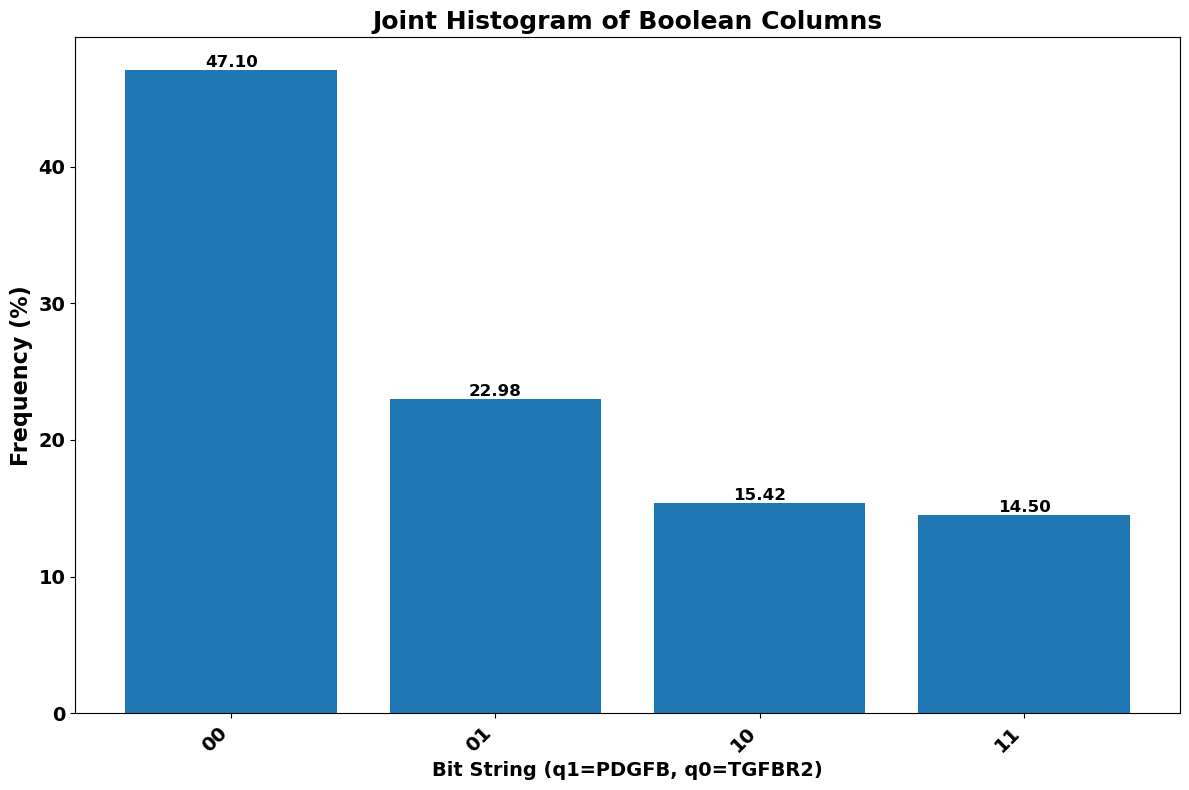

Joint Counts: {'01': 15.417256011315416, '10': 22.984441301272984, '00': 47.1004243281471, '11': 14.497878359264499}
Bit Strings: ['00', '01', '10', '11']


In [84]:
#joint_counts_ct1_co, bit_strings_ct1_co = create_joint_histogram(Xct1_binary_co)
joint_counts_ct1_co, bit_strings_ct1_co = create_percent_joint_histogram(Xct1_binary_co)

num_qubits = Xct1_binary_co.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts_ct1_co, num_qubits, reverse_bits=True, features=gl_source)  # Pass num_qubits

print("Joint Counts:", joint_counts_ct1_co)
print("Bit Strings:", bit_strings_ct1_co)

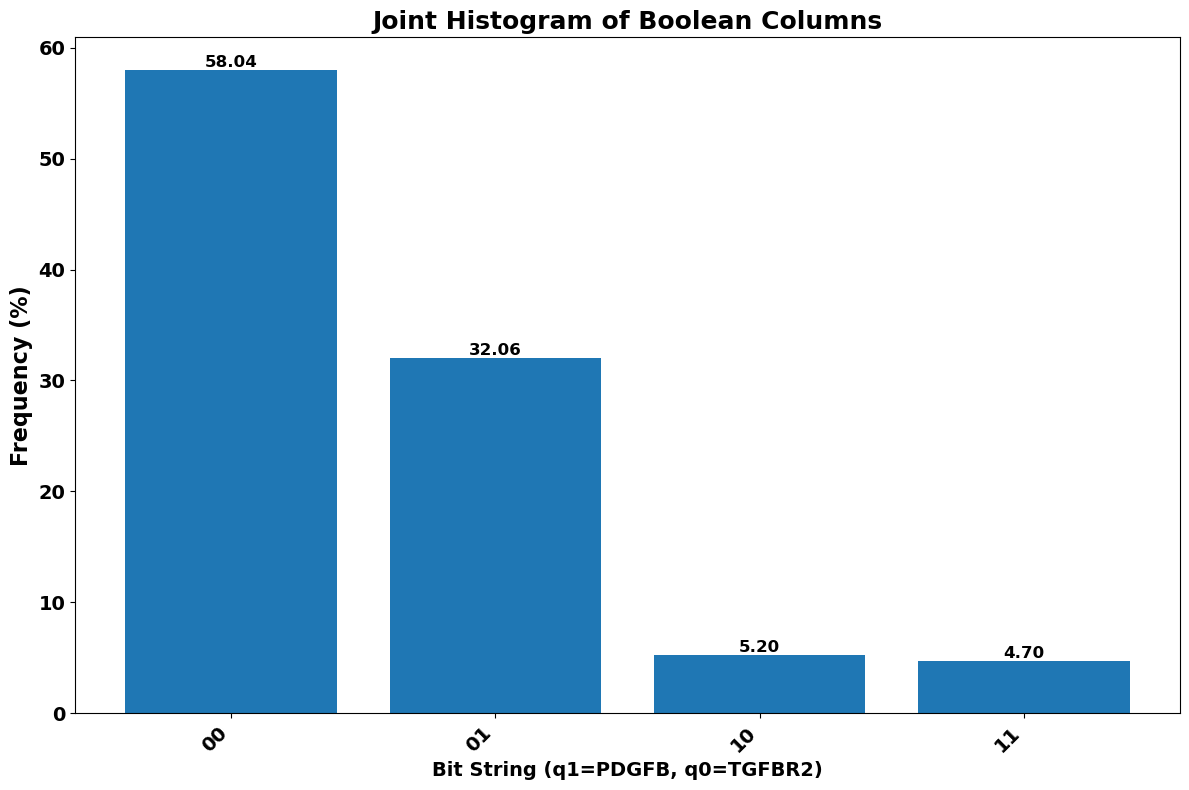

Joint Counts: {'00': 58.03722504230119, '11': 4.695431472081219, '10': 32.06429780033841, '01': 5.203045685279188}
Bit Strings: ['00', '01', '10', '11']


In [85]:
#joint_counts_ct1_mo, bit_strings_ct1_mo = create_joint_histogram(Xct1_binary_mo)
joint_counts_ct1_mo, bit_strings_ct1_mo = create_percent_joint_histogram(Xct1_binary_mo)

num_qubits = Xct1_binary_mo.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts_ct1_mo, num_qubits, reverse_bits=True, features=gl_source )  # Pass num_qubits

print("Joint Counts:", joint_counts_ct1_mo)
print("Bit Strings:", bit_strings_ct1_mo)

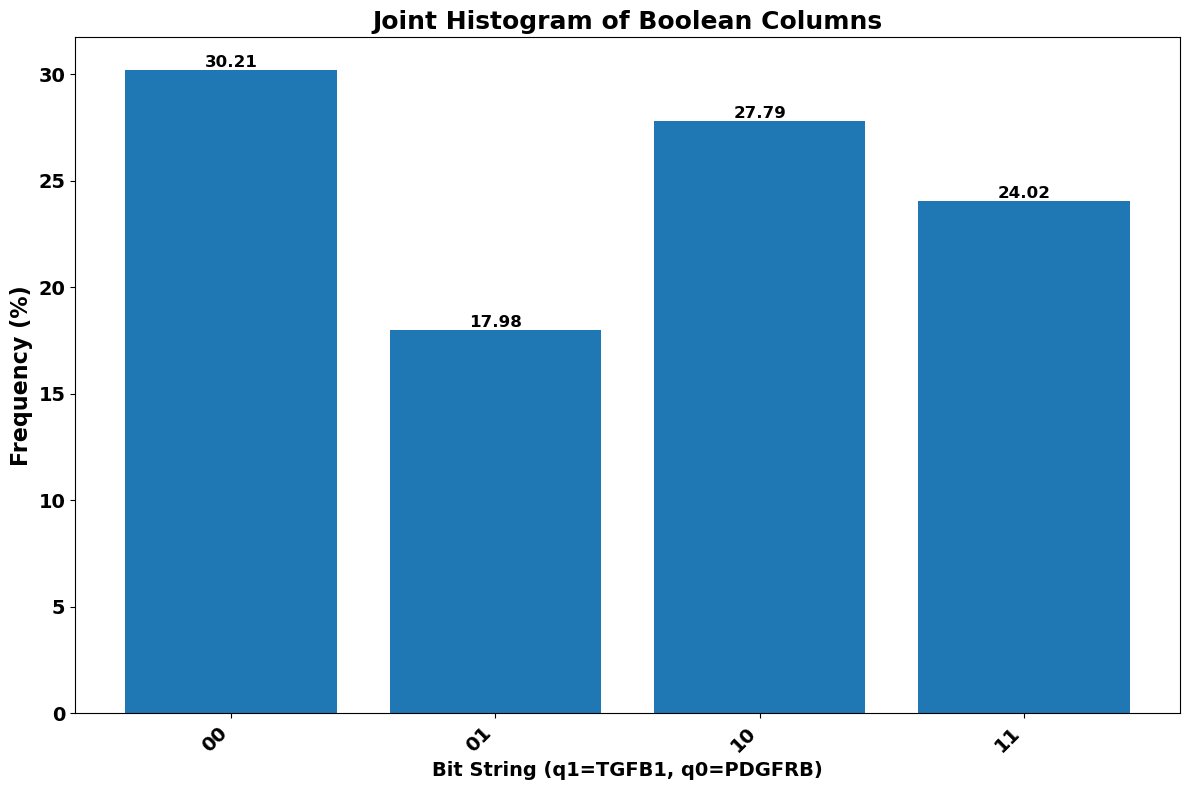

Joint Counts: {'00': 30.211480362537763, '11': 24.018126888217523, '01': 27.794561933534744, '10': 17.97583081570997}
Bit Strings: ['00', '01', '10', '11']


In [86]:
#joint_counts_ct2_co, bit_strings_ct2_co = create_joint_histogram(Xct2_binary_co)
joint_counts_ct2_co, bit_strings_ct2_co = create_percent_joint_histogram(Xct2_binary_co)

num_qubits2 = Xct2_binary_co.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts_ct2_co, num_qubits2, reverse_bits=True, features=gl_recv)  # Pass num_qubits

print("Joint Counts:", joint_counts_ct2_co)
print("Bit Strings:", bit_strings_ct2_co)

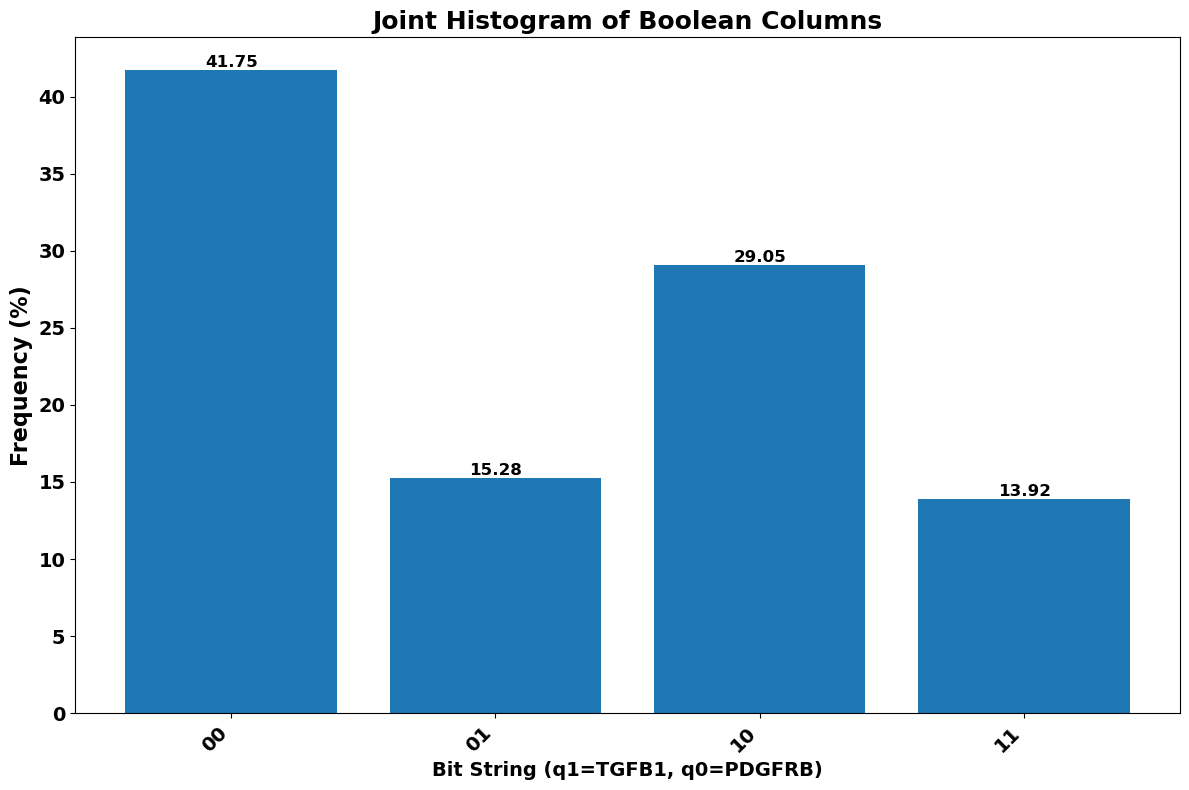

Joint Counts: {'11': 13.916786226685796, '00': 41.75035868005739, '01': 29.053084648493545, '10': 15.27977044476327}
Bit Strings: ['00', '01', '10', '11']


In [87]:
#joint_counts_ct2_mo, bit_strings_ct2_mo = create_joint_histogram(Xct2_binary_mo)
joint_counts_ct2_mo, bit_strings_ct2_mo = create_percent_joint_histogram(Xct2_binary_mo)

num_qubits2 = Xct2_binary_mo.shape[1]  # Get the number of qubits (important!)
plot_joint_histogram(joint_counts_ct2_mo, num_qubits2, reverse_bits=True, features=gl_recv)  # Pass num_qubits

print("Joint Counts:", joint_counts_ct2_mo)
print("Bit Strings:", bit_strings_ct2_mo)

In [88]:
import sys
import os

# Replace with your actual path
cc_grn_functions_path = r"C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions"
sys.path.append(cc_grn_functions_path)

from quantum_functions import create_grn_ansatz, create_interaction_observable_from_histogram, evaluate_and_plot_ansatz
from quantum_functions import create_parameter_dictionaries, cost_func_vqe, cost_func_wrapper
from quantum_functions import create_interaction_observable_general, create_parameter_dictionaries_from_circuit, create_circuit_lr2


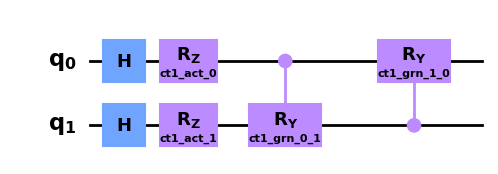

In [89]:
ng_ct1 = len(gl_source)  # Assuming gl_source is defined elsewhere
# Create mono coltured grn
ansatz_grn_ct1_mo = create_grn_ansatz(ng_ct1, "CT1")
# Create co cultured grn
ansatz_grn_ct1_co = create_grn_ansatz(ng_ct1, "CT1")
ansatz_grn_ct1_mo.draw(output="mpl", style="clifford", fold=40)

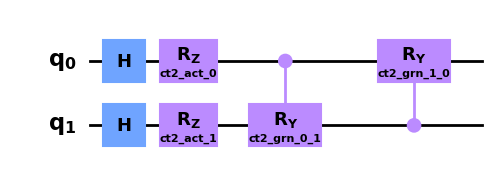

In [90]:
ng_ct2 = len(gl_recv)  #Example for a second cell type
# Create mo cultured grn
ansatz_grn_ct2_mo = create_grn_ansatz(ng_ct2, "CT2")
# Create co cultured grn
ansatz_grn_ct2_co = create_grn_ansatz(ng_ct2, "CT2")
ansatz_grn_ct2_mo.draw(output="mpl", style="clifford", fold=40)

Interaction observable CT1 from histogram: SparsePauliOp(['IZ', 'ZI', 'ZZ'],
              coeffs=[-15.41725601+0.j, -22.9844413 +0.j, -14.49787836+0.j])
Static Parameters: {Parameter(ct1_act_0): 2.3550836017009766, Parameter(ct1_act_1): 1.8796233273953076}
Variable Parameters: [Parameter(ct1_grn_0_1), Parameter(ct1_grn_1_0)]
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -1.3263403520545802
        x: [ 1.741e+00 -9.824e-01]
      nit: 9
      jac: [-4.441e-06 -1.776e-07]
     nfev: 39
     njev: 13
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


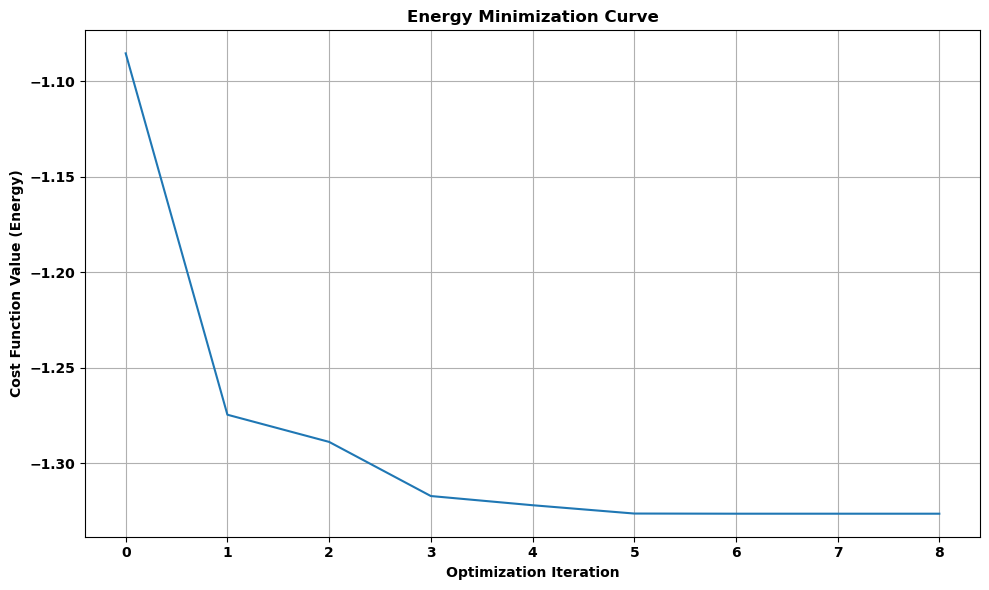

In [91]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

min_ones_ct1 = 1 # 1 is good 2 produces clean cuts
num_features = Xct1_binary_co.shape[1]  # Get the number of features dynamically

interaction_observable_ct1_co = create_interaction_observable_from_histogram(joint_counts_ct1_co, num_features, min_ones = min_ones_ct1)
print("Interaction observable CT1 from histogram:", interaction_observable_ct1_co)

static_params, variable_params = create_parameter_dictionaries(ansatz_grn_ct1_co, ct1_percentages_co)

print("Static Parameters:", static_params)
print("Variable Parameters:", variable_params)

estimator = StatevectorEstimator()

# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params_ct1_co = static_params.copy()  # Start with static parameters
all_params_ct1_co.update(dict(zip(variable_params, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params_ct1_co, ansatz_grn_ct1_co, interaction_observable_ct1_co, estimator, variable_params), # Pass all the arguments as a tuple
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params_ct1_co, ansatz_grn_ct1_co, interaction_observable_ct1_co, estimator, variable_params))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params, optimized_variable_parameters):
    all_params_ct1_co[param] = value

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

Interaction observable CT1 from histogram: SparsePauliOp(['ZZ', 'ZI', 'IZ'],
              coeffs=[ -4.69543147+0.j, -32.0642978 +0.j,  -5.20304569+0.j])
Static Parameters: {Parameter(ct1_act_0): 2.3096819086036633, Parameter(ct1_act_1): 0.6219396623857967}
Variable Parameters: [Parameter(ct1_grn_0_1), Parameter(ct1_grn_1_0)]
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -11.162598336784672
        x: [-1.566e+00  7.711e-01]
      nit: 7
      jac: [ 5.329e-07  0.000e+00]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


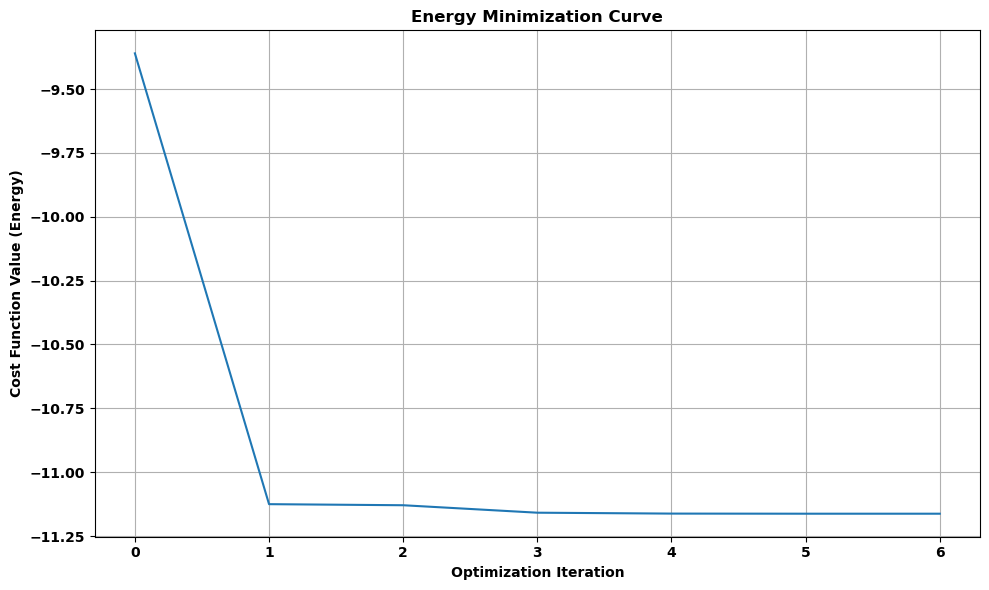

In [92]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

num_features = Xct1_binary_mo.shape[1]  # Get the number of features dynamically

interaction_observable_ct1_mo = create_interaction_observable_from_histogram(joint_counts_ct1_mo, num_features, min_ones = min_ones_ct1)
print("Interaction observable CT1 from histogram:", interaction_observable_ct1_mo)

static_params, variable_params = create_parameter_dictionaries(ansatz_grn_ct1_mo, ct1_percentages_mo)

print("Static Parameters:", static_params)
print("Variable Parameters:", variable_params)

estimator = StatevectorEstimator()

# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params_ct1_mo = static_params.copy()  # Start with static parameters
all_params_ct1_mo.update(dict(zip(variable_params, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params_ct1_mo, ansatz_grn_ct1_mo, interaction_observable_ct1_mo, estimator, variable_params), # Pass all the arguments as a tuple
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params_ct1_mo, ansatz_grn_ct1_mo, interaction_observable_ct1_mo, estimator, variable_params))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params, optimized_variable_parameters):
    all_params_ct1_mo[param] = value

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

The counts are: {'01': 320, '10': 290, '11': 164, '00': 250}


C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions\quantum_functions.py:177: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, bar_labels=True, title=title).show()


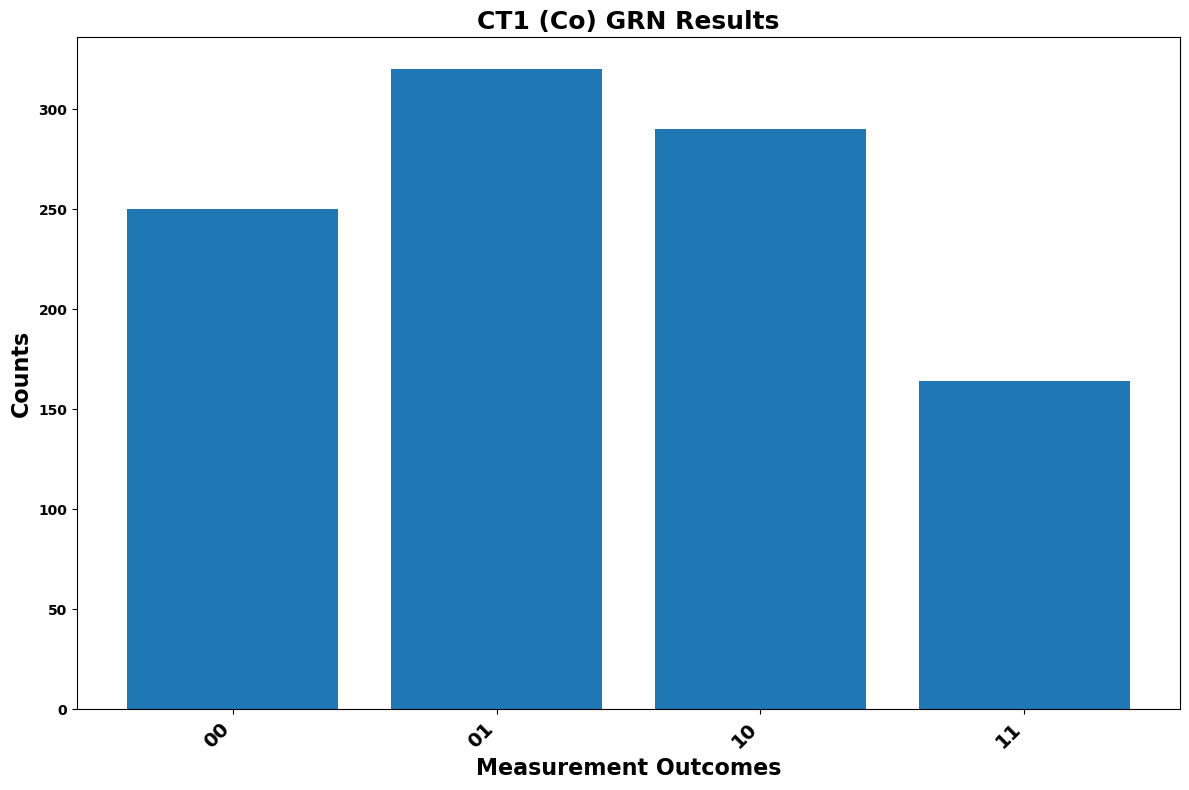

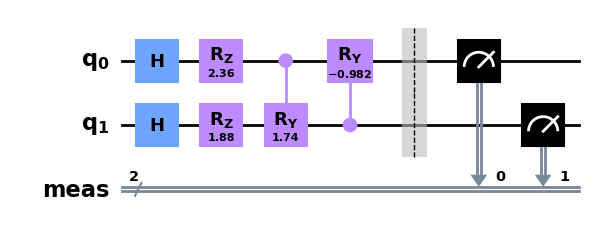

In [93]:
#counts_ct1_co, bound_circuit_ct1_co = evaluate_and_plot_ansatz(ansatz_grn_ct1_co, all_params_ct1_co, shots=sum(joint_counts_ct1_co.values()), title="CT1 (Co) GRN Results")
counts_ct1_co, bound_circuit_ct1_co = evaluate_and_plot_ansatz(ansatz_grn_ct1_co, all_params_ct1_co, shots=1024, title="CT1 (Co) GRN Results")

bound_circuit_ct1_co.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

The counts are: {'01': 462, '10': 297, '00': 260, '11': 5}


C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions\quantum_functions.py:177: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, bar_labels=True, title=title).show()


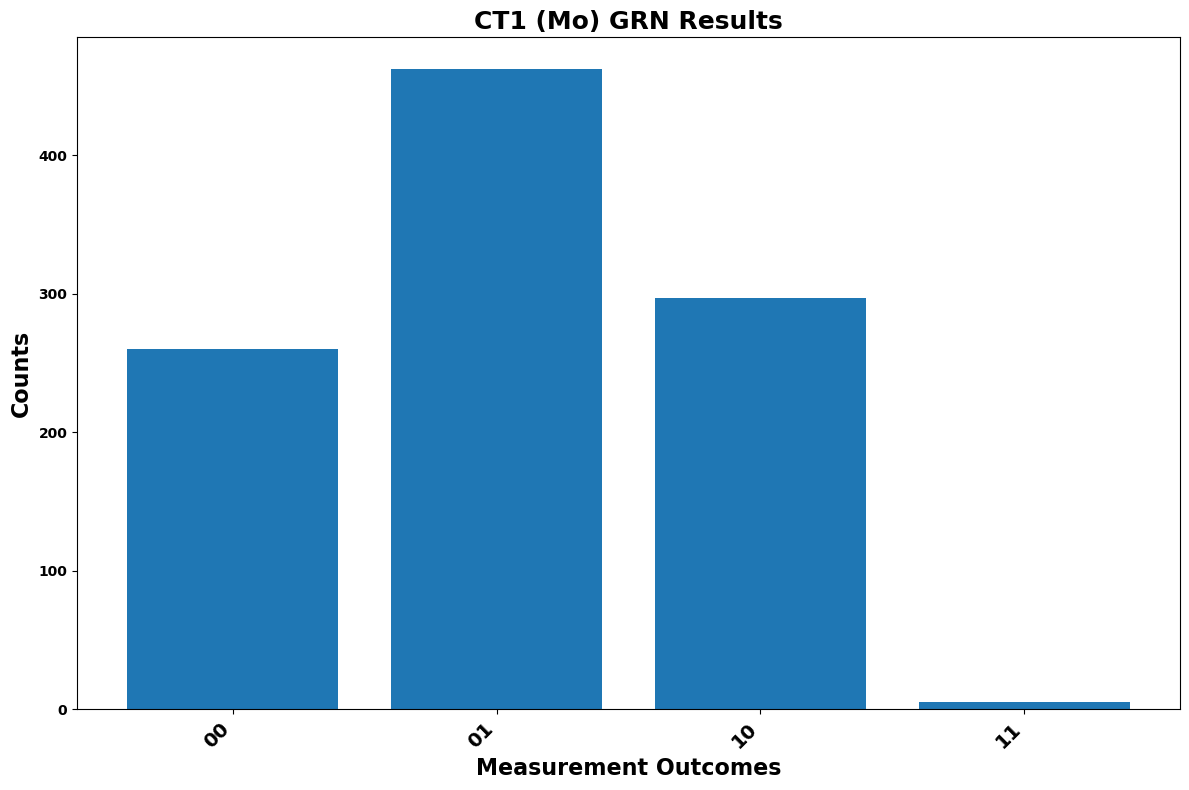

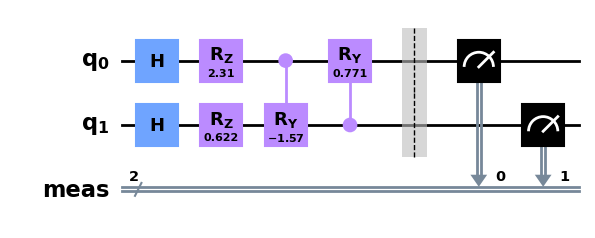

In [94]:
# Generating monocultured hitogram from ciruit
#counts_ct1_mo, bound_circuit_ct1_mo = evaluate_and_plot_ansatz(ansatz_grn_ct1_mo, all_params_ct1_mo, shots=sum(joint_counts_ct1_mo.values()), title="CT1 (Mo) GRN Results")
counts_ct1_mo, bound_circuit_ct1_mo = evaluate_and_plot_ansatz(ansatz_grn_ct1_mo, all_params_ct1_mo, shots=1024, title="CT1 (Mo) GRN Results")
bound_circuit_ct1_mo.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

Interaction observable CT2 from histogram: SparsePauliOp(['ZZ', 'IZ', 'ZI'],
              coeffs=[-24.01812689+0.j, -27.79456193+0.j, -17.97583082+0.j])
Static Parameters: {Parameter(ct2_act_0): 2.638558180356382, Parameter(ct2_act_1): 3.255487251303018}
Variable Parameters: [Parameter(ct2_grn_0_1), Parameter(ct2_grn_1_0)]
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -6.385542460684738
        x: [-1.563e+00  1.964e+00]
      nit: 8
      jac: [-1.776e-07  1.776e-07]
     nfev: 33
     njev: 11
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


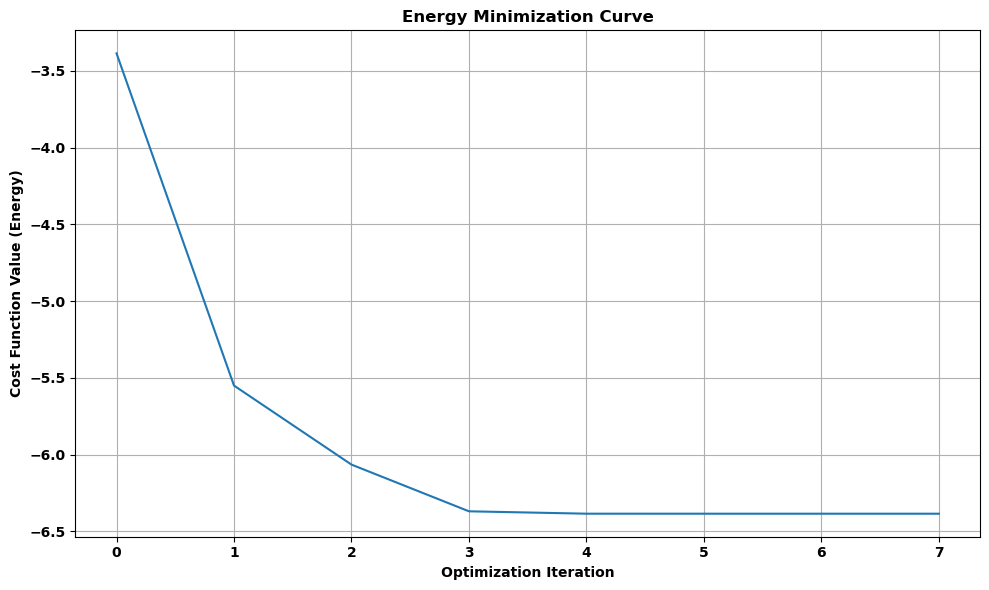

In [95]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

min_ones_ct2 = 1 # 1 is fine... 2 produces cleaner cuts
num_features2 = Xct2_binary_co.shape[1]  # Get the number of features dynamically

interaction_observable_ct2_co = create_interaction_observable_from_histogram(joint_counts_ct2_co, num_features2, min_ones = min_ones_ct2)
print("Interaction observable CT2 from histogram:", interaction_observable_ct2_co)

static_params2, variable_params2 = create_parameter_dictionaries(ansatz_grn_ct2_co, ct2_percentages_co)

print("Static Parameters:", static_params2)
print("Variable Parameters:", variable_params2)

estimator = StatevectorEstimator()
# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params2))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params_ct2_co = static_params2.copy()  # Start with static parameters
all_params_ct2_co.update(dict(zip(variable_params2, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args, using a lambda for the callback
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params_ct2_co, ansatz_grn_ct2_co, interaction_observable_ct2_co, estimator, variable_params2),
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params_ct2_co, ansatz_grn_ct2_co, interaction_observable_ct2_co, estimator, variable_params2))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params2, optimized_variable_parameters):
    all_params_ct2_co[param] = value

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

Interaction observable CT2 from histogram: SparsePauliOp(['ZZ', 'IZ', 'ZI'],
              coeffs=[-13.91678623+0.j, -29.05308465+0.j, -15.27977044+0.j])
Static Parameters: {Parameter(ct2_act_0): 1.8344737589828493, Parameter(ct2_act_1): 2.6998766133433083}
Variable Parameters: [Parameter(ct2_grn_0_1), Parameter(ct2_grn_1_0)]
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -8.815005576655055
        x: [-1.721e+00  2.165e+00]
      nit: 9
      jac: [-1.776e-07 -1.776e-07]
     nfev: 45
     njev: 15
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


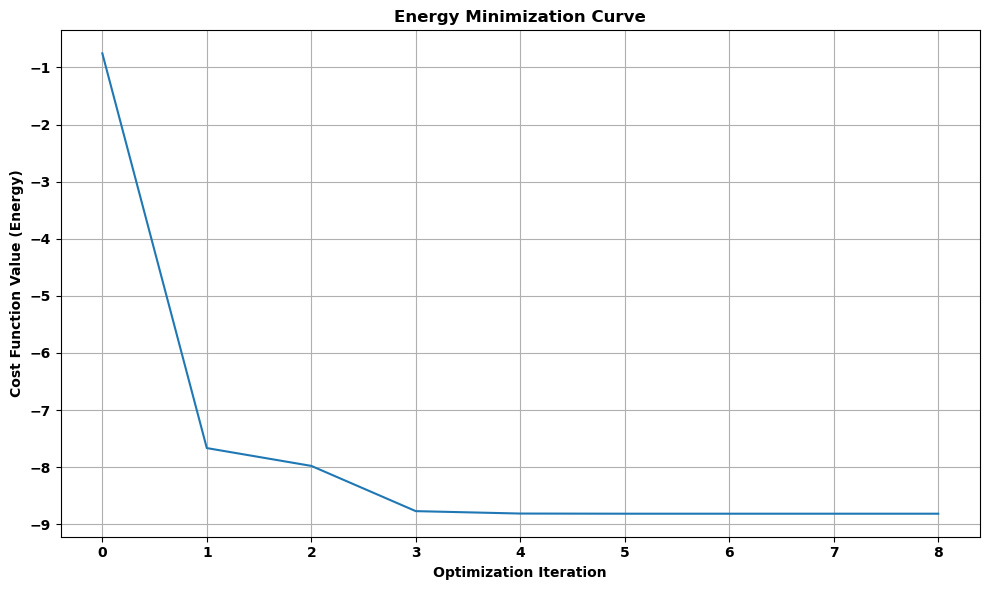

In [96]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize

num_features2 = Xct2_binary_mo.shape[1]  # Get the number of features dynamically

interaction_observable_ct2_mo = create_interaction_observable_from_histogram(joint_counts_ct2_mo, num_features2, min_ones = min_ones_ct2)
print("Interaction observable CT2 from histogram:", interaction_observable_ct2_mo)

static_params2, variable_params2 = create_parameter_dictionaries(ansatz_grn_ct2_mo, ct2_percentages_mo)

print("Static Parameters:", static_params2)
print("Variable Parameters:", variable_params2)

estimator = StatevectorEstimator()
# Initialize variable parameters
x0_interaction = np.zeros(len(variable_params2))  # All zeros

# Create initial full parameter dictionary - THIS IS THE KEY CHANGE
all_params_ct2_mo = static_params2.copy()  # Start with static parameters
all_params_ct2_mo.update(dict(zip(variable_params2, x0_interaction)))  # Add variable parameters

cost_values = []
# Call minimize with args, using a lambda for the callback
result_interaction_bfgs = minimize(
    cost_func_wrapper,
    x0_interaction,
    args=(all_params_ct2_mo, ansatz_grn_ct2_mo, interaction_observable_ct2_mo, estimator, variable_params2),
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params_ct2_mo, ansatz_grn_ct2_mo, interaction_observable_ct2_mo, estimator, variable_params2))
)

print(result_interaction_bfgs)

# --- 6. Results and DataFrame ---
optimized_variable_parameters = result_interaction_bfgs.x

# Update the full parameter dictionary with optimized variable parameters
for param, value in zip(variable_params2, optimized_variable_parameters):
    all_params_ct2_mo[param] = value

import matplotlib.pyplot as plt

# Plot the cost function values
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve")
plt.grid(True)
plt.tight_layout()
plt.show()

The counts are: {'00': 255, '10': 715, '11': 52, '01': 2}


C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions\quantum_functions.py:177: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, bar_labels=True, title=title).show()


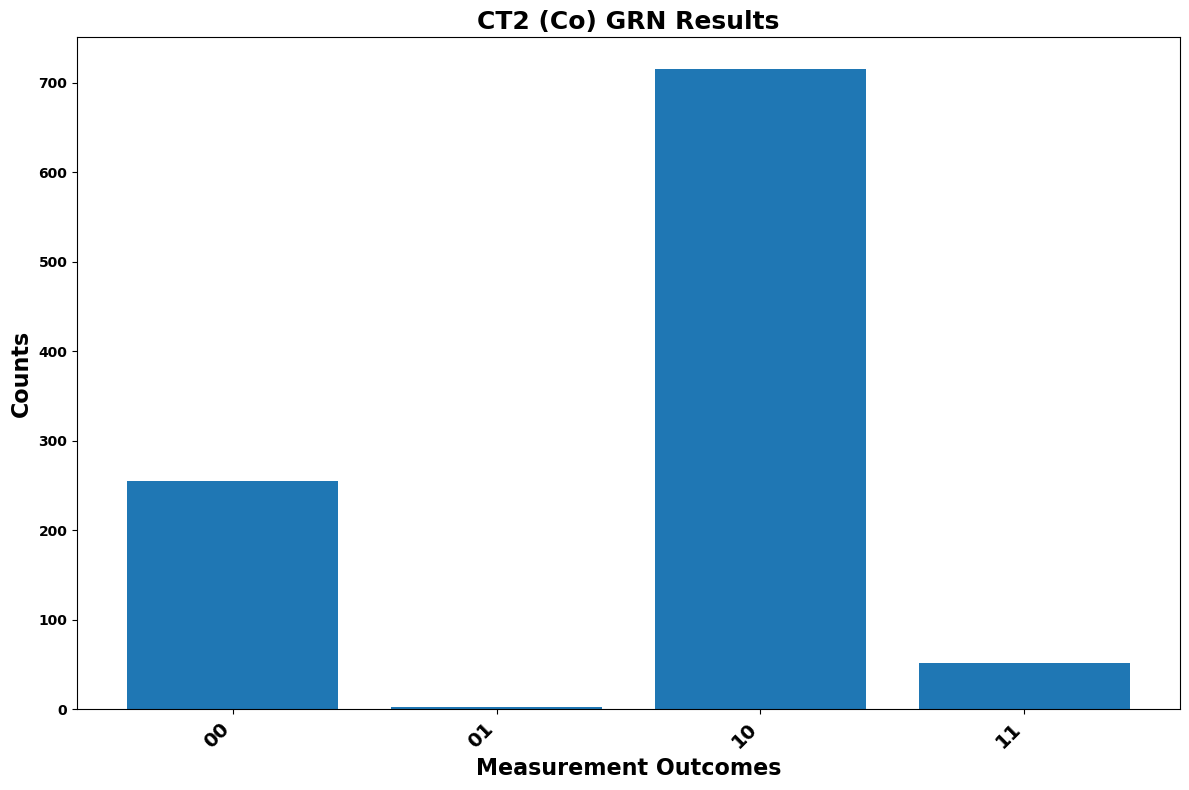

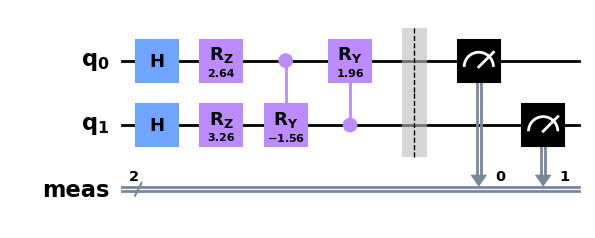

In [97]:
#counts_ct2_co, bound_circuit_ct2_co = evaluate_and_plot_ansatz(ansatz_grn_ct2_co, all_params_ct2_co,shots=sum(joint_counts_ct2_co.values()), title="CT2 (Co) GRN Results")
counts_ct2_co, bound_circuit_ct2_co = evaluate_and_plot_ansatz(ansatz_grn_ct2_co, all_params_ct2_co,shots=1024, title="CT2 (Co) GRN Results")
bound_circuit_ct2_co.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

The counts are: {'00': 264, '11': 149, '10': 587, '01': 24}


C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions\quantum_functions.py:177: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, bar_labels=True, title=title).show()


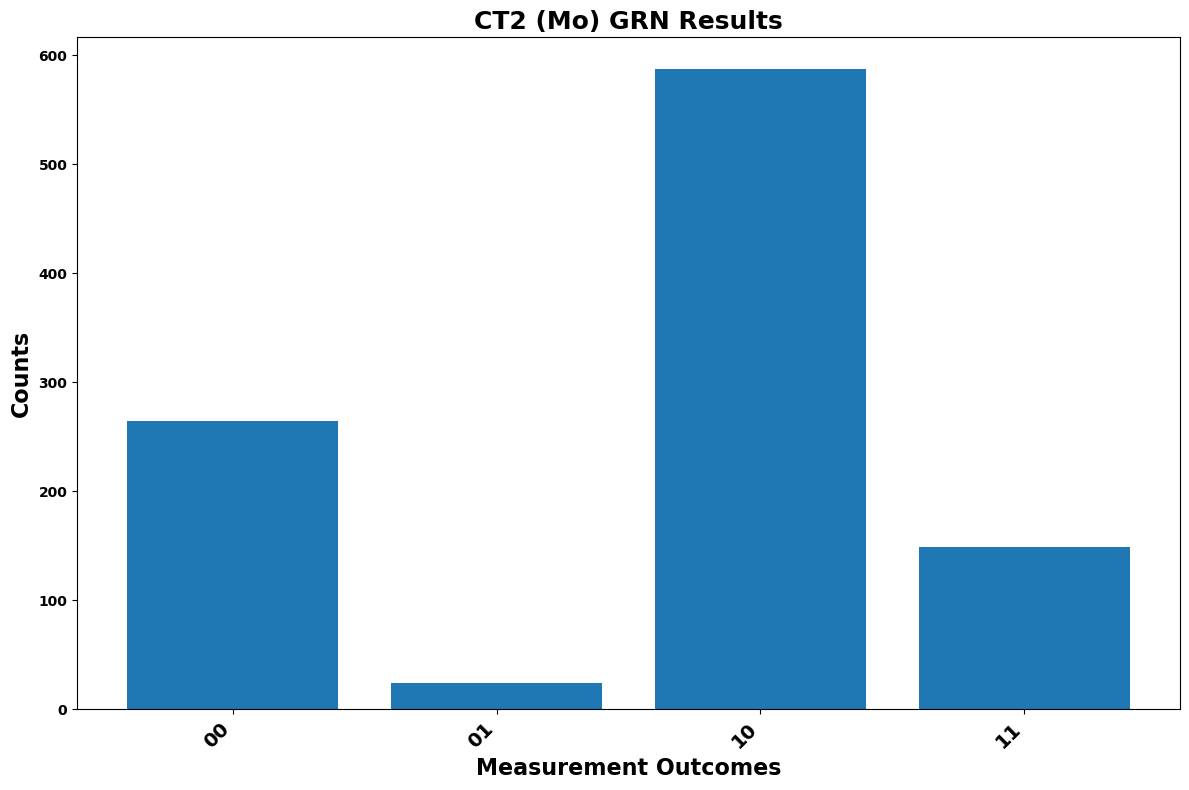

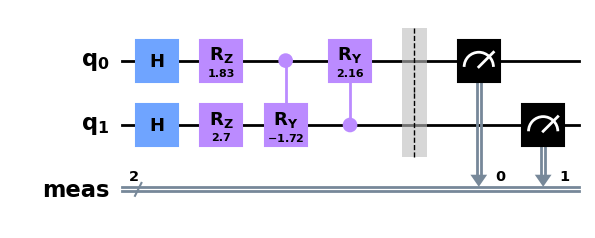

In [98]:
#counts_ct2_mo, bound_circuit_ct2_mo = evaluate_and_plot_ansatz(ansatz_grn_ct2_mo, all_params_ct2_mo, shots=sum(joint_counts_ct2_mo.values()), title="CT2 (Mo) GRN Results")
counts_ct2_mo, bound_circuit_ct2_mo = evaluate_and_plot_ansatz(ansatz_grn_ct2_mo, all_params_ct2_mo, shots=1024, title="CT2 (Mo) GRN Results")
bound_circuit_ct2_mo.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

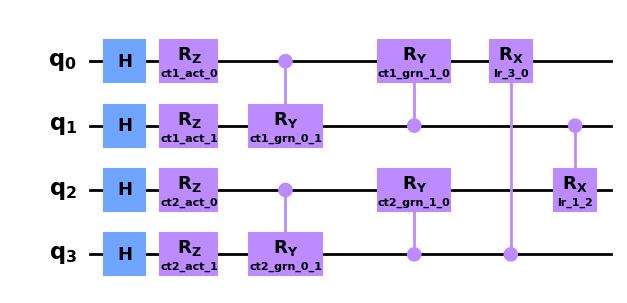

In [99]:
# interactions_lr = {
#     (4, 0): -1,
#     (3, 6): -1
# }
# interactions_lr = {
#     (ng_ct1 + ng_ct2 - 1, 0): 10,
#     (0, ng_ct1 + ng_ct2 - 1): 10,
#     (ng_ct1-1, ng_ct1): 10,
#     (ng_ct1, ng_ct1-1): 10
# }
interactions_lr = {
    (ng_ct1 + ng_ct2 - 1, 0): 10,
    (ng_ct1-1, ng_ct1): 10,
}
# interactions_lr = {
#     (ng_ct1-1, ng_ct1): 10,
# }
cc_grn_circuit_co = create_circuit_lr2(ansatz_grn_ct1_co, ansatz_grn_ct2_co, interactions = interactions_lr)
cc_grn_circuit_mo = create_circuit_lr2(ansatz_grn_ct1_mo, ansatz_grn_ct2_mo, interactions = interactions_lr)
cc_grn_circuit_mo.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

{Parameter(ct1_act_0): 2.3550836017009766, Parameter(ct1_act_1): 1.8796233273953076, Parameter(ct1_grn_0_1): 1.7406934551627438, Parameter(ct1_grn_1_0): -0.9824013537481802, Parameter(ct2_act_0): 2.638558180356382, Parameter(ct2_act_1): 3.255487251303018, Parameter(ct2_grn_0_1): -1.563063218529657, Parameter(ct2_grn_1_0): 1.964329339688475, Parameter(lr_1_2): 0.0, Parameter(lr_3_0): 0.0}
Interaction observable LR custom:  SparsePauliOp(['ZIIZ', 'IZZI'],
              coeffs=[-10.+0.j, -10.+0.j])
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -16.77472847463956
        x: [-2.710e+00 -1.633e+00]
      nit: 8
      jac: [-7.105e-07 -1.066e-06]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


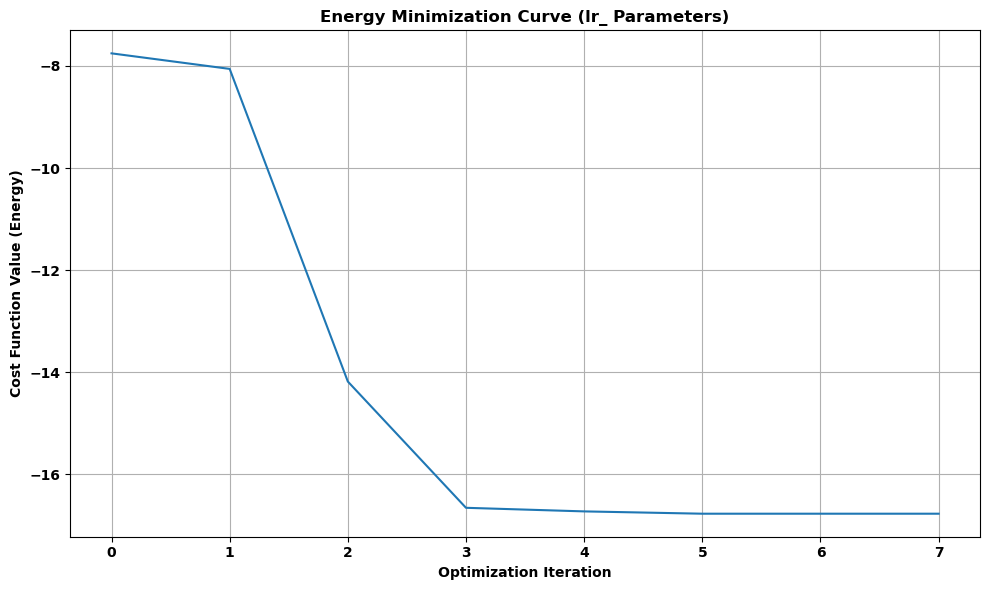

In [100]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector

estimator = StatevectorEstimator()

# --- 1. Create Static Parameter Dictionaries ---
static_params_lr, variable_params_lr = create_parameter_dictionaries_from_circuit(cc_grn_circuit_co)

# Update static_params_lr with values from all_params and all_params2
for param in static_params_lr:
    if param.name in [p.name for p in all_params_ct1_co]:
        # Access value directly by name
        static_params_lr[param] = all_params_ct1_co[next(p for p in all_params_ct1_co if p.name == param.name)]
    elif param.name in [p.name for p in all_params_ct2_co]:
        # Access value directly by name
        static_params_lr[param] = all_params_ct2_co[next(p for p in all_params_ct2_co if p.name == param.name)]
        
x0_lr = np.zeros(len(variable_params_lr))  # Initial lr_ values

# Create the combined parameter dictionary.
all_params_lr_co = static_params_lr.copy()
all_params_lr_co.update(dict(zip(variable_params_lr, x0_lr)))

print(all_params_lr_co)

interaction_observable_lr_co = create_interaction_observable_general(interactions_lr, ng_ct1 + ng_ct2)
print("Interaction observable LR custom: ", interaction_observable_lr_co)

cost_values = []
result_lr_bfgs = minimize(
    cost_func_wrapper, 
    x0_lr,
    args=(all_params_lr_co, cc_grn_circuit_co, interaction_observable_lr_co, estimator, variable_params_lr),  # Correct args
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params_lr_co, cc_grn_circuit_co, interaction_observable_lr_co, estimator, variable_params_lr))  # Correct callback
)

print(result_lr_bfgs)

# --- 6. Results and DataFrame ---
optimized_lr_values = result_lr_bfgs.x

# Update the lr_ parameters in the combined dictionary (optional)
all_params_lr_co.update(dict(zip(variable_params_lr, optimized_lr_values)))

# --- 7. Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve (lr_ Parameters)")
plt.grid(True)
plt.tight_layout()
plt.show()


{Parameter(ct1_act_0): 2.3096819086036633, Parameter(ct1_act_1): 0.6219396623857967, Parameter(ct1_grn_0_1): -1.5663485134370587, Parameter(ct1_grn_1_0): 0.7711444742525265, Parameter(ct2_act_0): 1.8344737589828493, Parameter(ct2_act_1): 2.6998766133433083, Parameter(ct2_grn_0_1): -1.720941203486042, Parameter(ct2_grn_1_0): 2.164982518430156, Parameter(lr_1_2): 0.0, Parameter(lr_3_0): 0.0}
Interaction observable LR custom:  SparsePauliOp(['ZIIZ', 'IZZI'],
              coeffs=[-10.+0.j, -10.+0.j])
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -8.934918921819667
        x: [-2.423e+00 -1.885e+00]
      nit: 5
      jac: [-1.776e-07 -3.553e-07]
     nfev: 30
     njev: 10
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


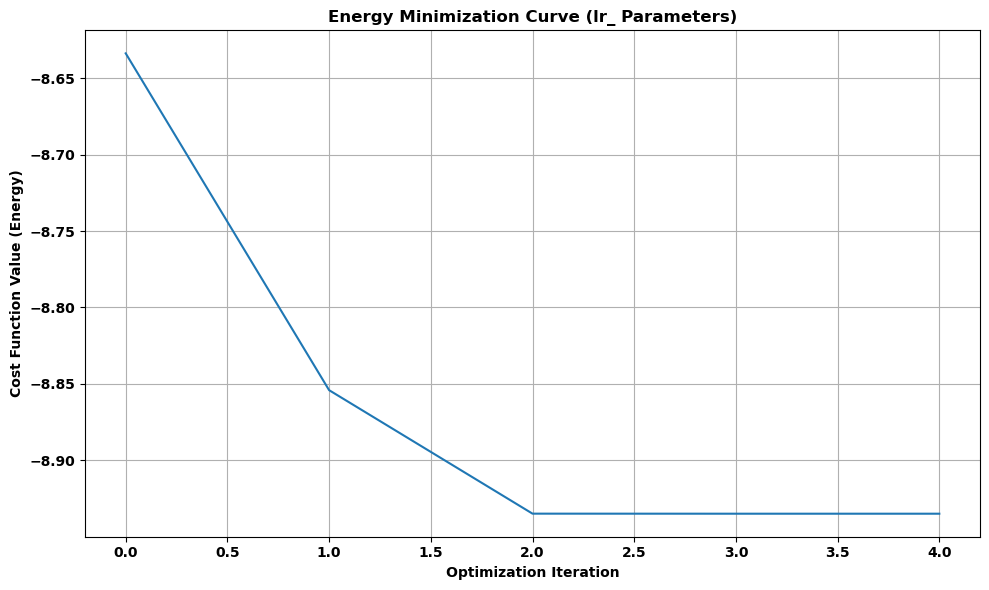

In [101]:
from qiskit.primitives import StatevectorEstimator
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector

estimator = StatevectorEstimator()

# --- 1. Create Static Parameter Dictionaries ---
static_params_lr, variable_params_lr = create_parameter_dictionaries_from_circuit(cc_grn_circuit_mo)

# Update static_params_lr with values from all_params and all_params2
for param in static_params_lr:
    if param.name in [p.name for p in all_params_ct1_mo]:
        # Access value directly by name
        static_params_lr[param] = all_params_ct1_mo[next(p for p in all_params_ct1_mo if p.name == param.name)]
    elif param.name in [p.name for p in all_params_ct2_mo]:
        # Access value directly by name
        static_params_lr[param] = all_params_ct2_mo[next(p for p in all_params_ct2_mo if p.name == param.name)]

x0_lr = np.zeros(len(variable_params_lr))  # Initial lr_ values

# Create the combined parameter dictionary.
all_params_lr_mo = static_params_lr.copy()
all_params_lr_mo.update(dict(zip(variable_params_lr, x0_lr)))

print(all_params_lr_mo)

interaction_observable_lr_mo = create_interaction_observable_general(interactions_lr, ng_ct1 + ng_ct2)
print("Interaction observable LR custom: ", interaction_observable_lr_mo)

cost_values = []
result_lr_bfgs = minimize(
    cost_func_wrapper, 
    x0_lr,
    args=(all_params_lr_mo, cc_grn_circuit_mo, interaction_observable_lr_mo, estimator, variable_params_lr),  # Correct args
    method="L-BFGS-B",
    callback=lambda xk: cost_values.append(cost_func_wrapper(xk, all_params_lr_mo, cc_grn_circuit_mo, interaction_observable_lr_mo, estimator, variable_params_lr))  # Correct callback
)

print(result_lr_bfgs)

# --- 6. Results and DataFrame ---
optimized_lr_values = result_lr_bfgs.x

# Update the lr_ parameters in the combined dictionary (optional)
all_params_lr_mo.update(dict(zip(variable_params_lr, optimized_lr_values)))

# --- 7. Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(cost_values)
plt.xlabel("Optimization Iteration")
plt.ylabel("Cost Function Value (Energy)")
plt.title("Energy Minimization Curve (lr_ Parameters)")
plt.grid(True)
plt.tight_layout()
plt.show()

The counts are: {'1001': 780, '0001': 195, '0000': 141, '1111': 663, '1101': 56, '0111': 55, '0110': 124, '1110': 9, '1000': 11, '0101': 2, '0010': 4, '0100': 1, '0011': 3, '1011': 3, '1100': 1}


C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions\quantum_functions.py:177: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, bar_labels=True, title=title).show()


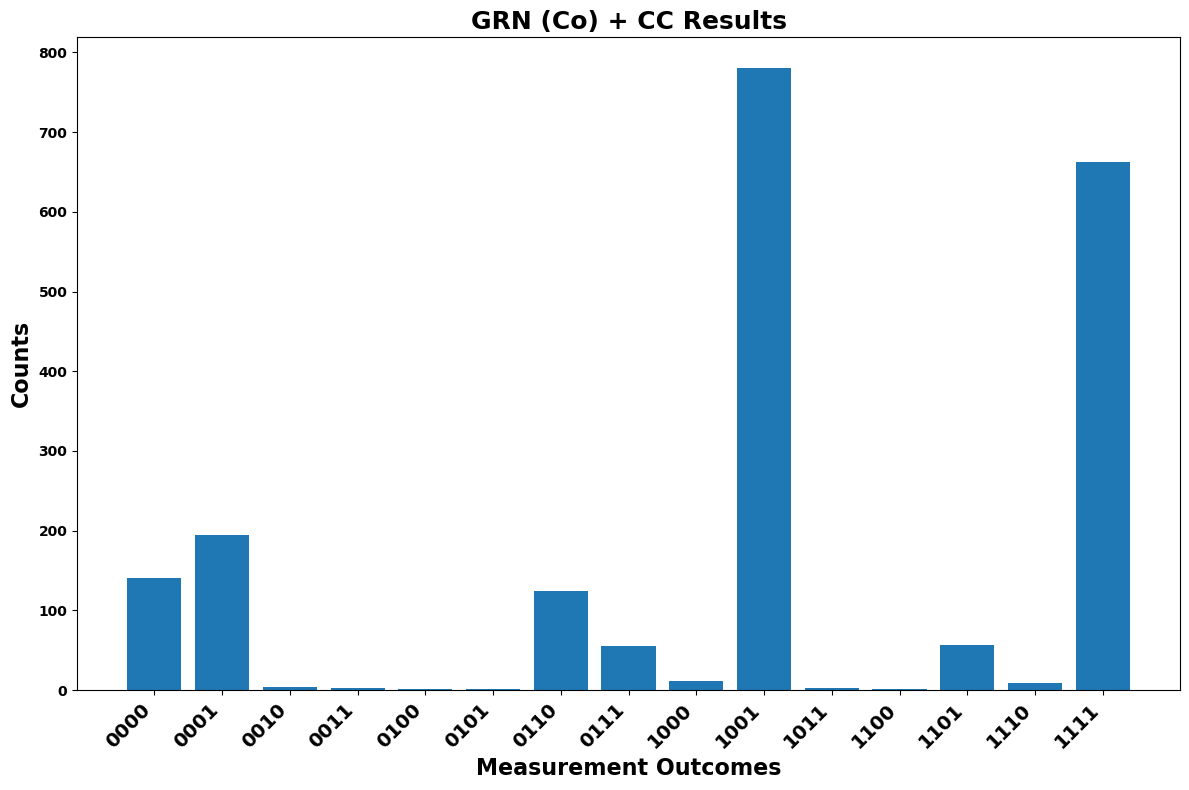

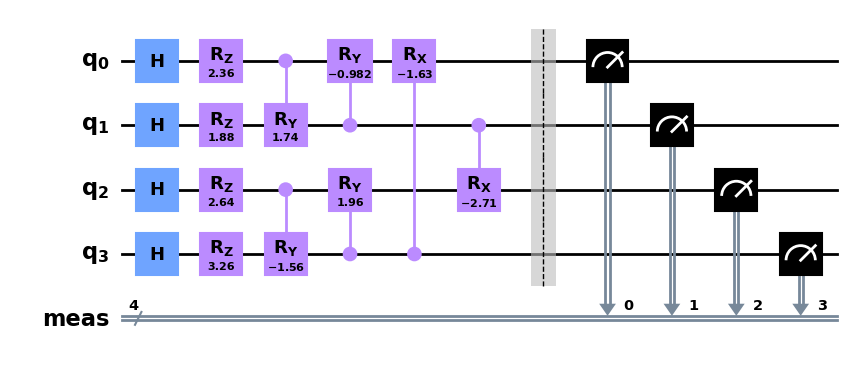

In [102]:
counts_cc_grn_co, bound_circuit_cc_grn_co = evaluate_and_plot_ansatz(cc_grn_circuit_co, all_params_lr_co, shots=2048, title="GRN (Co) + CC Results")
bound_circuit_cc_grn_co.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

The counts are: {'1111': 216, '1100': 82, '1110': 246, '0001': 220, '1001': 559, '0110': 113, '1000': 237, '0000': 125, '0101': 17, '1101': 163, '0010': 44, '0100': 15, '1010': 5, '0111': 3, '1011': 3}


C:\Users\ssromerogon\Documents\vscode_working_dir\QuantumXCT\python\cc_grn_functions\quantum_functions.py:177: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot_histogram(counts, bar_labels=True, title=title).show()


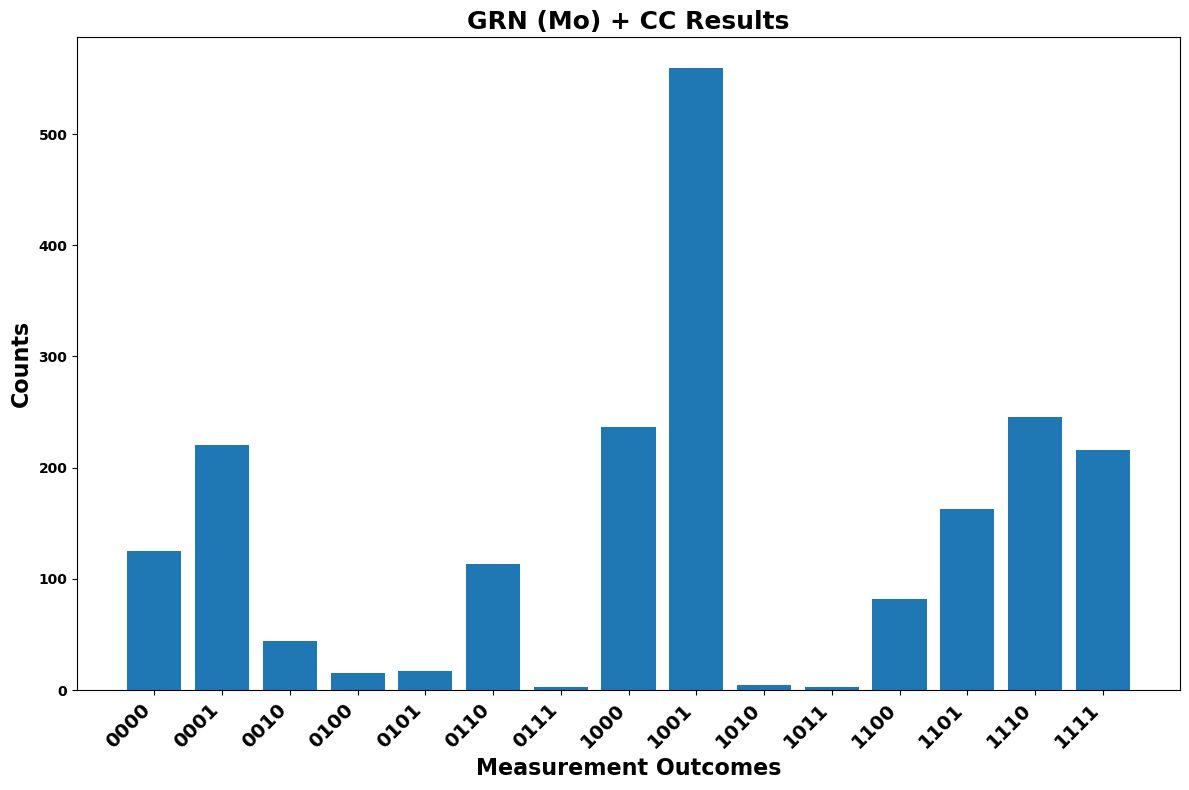

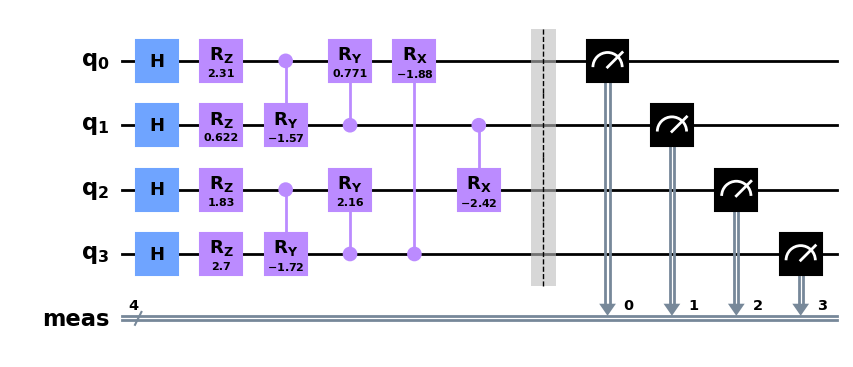

In [103]:
counts_cc_grn_mo, bound_circuit_cc_grn_mo = evaluate_and_plot_ansatz(cc_grn_circuit_mo, all_params_lr_mo, shots=2048, title="GRN (Mo) + CC Results")
bound_circuit_cc_grn_mo.draw(output="mpl", style="clifford", fold=40)  # Show the circuit plot

In [104]:
def filter_bitstrings_from_interactions(interactions_lr, num_qubits):
    """
    Generates bit string patterns based on the given interactions_lr
    for plotting specific bitstring patterns.
    Args:
        interactions_lr (dict): A dictionary representing interactions,
                                 where keys are tuples of qubit indices
                                 and values are interaction strengths.
        num_qubits (int): The total number of qubits in the system.

    Returns:
        list: A list of bit string patterns with '1' at the interacting
              qubit positions and '0' elsewhere.
    """
    patterns = []
    for interaction in interactions_lr:
        pattern = ['.'] * num_qubits
        for qubit_index in interaction:
            if 0 <= qubit_index < num_qubits:
                pattern[num_qubits - 1 - qubit_index] = '1'  # Adjust for bit order
        patterns.append("".join(pattern))
    return patterns

bitstring_patterns = filter_bitstrings_from_interactions(interactions_lr, cc_grn_circuit_co.num_qubits)
print(bitstring_patterns)


['1..1', '.11.']


In [105]:
def combine_patterns(patterns):
  """Combines patterns like '1.....1' and '.11...' into '111...1'.

  Args:
    patterns: A list of strings representing patterns.

  Returns:
    A string representing the combined pattern.
  """
  if not patterns:
    return ""

  max_length = max(len(pattern) for pattern in patterns)
  combined = ['0'] * max_length  # Initialize with '0's

  for pattern in patterns:
    padded_pattern = pattern.ljust(max_length, '.')  # Pad with '.'

    for i, char in enumerate(padded_pattern):
      if char == '1':
        combined[i] = '1'

  return "".join(combined)

bitstring_patterns_comb = combine_patterns(bitstring_patterns)


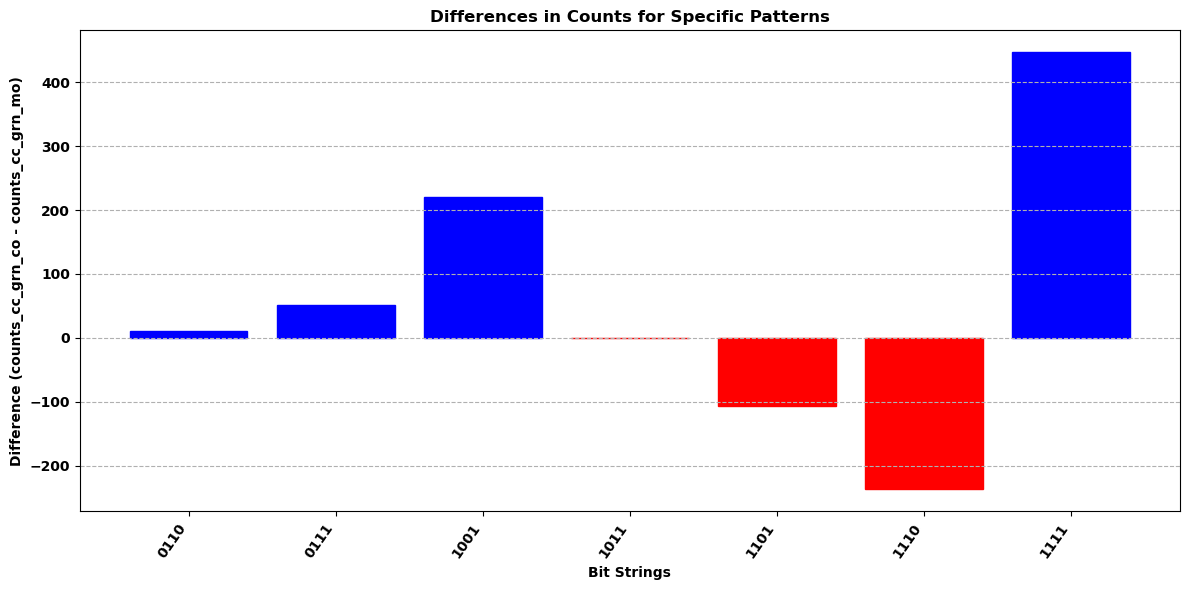

In [106]:
import matplotlib.pyplot as plt
import numpy as np

differences = {}

# Calculate the differences, handling cases where bitstrings are not common
all_bitstrings = set(counts_cc_grn_co.keys()) | set(counts_cc_grn_mo.keys())

for key in all_bitstrings:
    count_co = counts_cc_grn_co.get(key, 0)
    count_mo = counts_cc_grn_mo.get(key, 0)
    differences[key] = count_co - count_mo

def matches_pattern(bitstring, pattern):
    if len(bitstring) != len(pattern):
        return False
    for i in range(len(bitstring)):
        if pattern[i] != '.' and pattern[i] != bitstring[i]:
            return False
    return True

# Filter bitstrings based on the defined patterns
filtered_bitstrings = []
filtered_differences = []

for bitstring, difference in differences.items():
    for pattern in bitstring_patterns:
        if matches_pattern(bitstring, pattern):
            filtered_bitstrings.append(bitstring)
            filtered_differences.append(difference)
            break # Move to the next bitstring once a match is found

# Sort the filtered bitstrings for better visualization
sorted_indices = np.argsort(filtered_bitstrings)
filtered_bitstrings = [filtered_bitstrings[i] for i in sorted_indices]
filtered_differences = [filtered_differences[i] for i in sorted_indices]

# Create the bar plot with filtered data
plt.figure(figsize=(12, 6))
bars = plt.bar(filtered_bitstrings, filtered_differences, edgecolor='black')

# Color the bars based on the sign of the difference
for bar, diff in zip(bars, filtered_differences):
    if diff > 0:
        bar.set_color('blue')  # Or another color for positive differences
    else:
        bar.set_color('red')   # Or another color for negative differences


plt.xlabel('Bit Strings')
plt.ylabel('Difference (counts_cc_grn_co - counts_cc_grn_mo)')
plt.title(f'Differences in Counts for Specific Patterns')
plt.xticks(rotation=55, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()

In [107]:
print(gl_recv[::-1], gl_source[::-1])

['TGFB1', 'PDGFRB'] ['PDGFB', 'TGFBR2']


       Prob_0_co  Prob_1_co  Prob_0_mo  Prob_1_mo
Qubit                                            
0       0.143618   0.856382   0.417135   0.582865
1       0.574891   0.425109   0.703185   0.296815
2       0.547913   0.452087   0.596101   0.403899
3       0.251627   0.748373   0.276538   0.723462


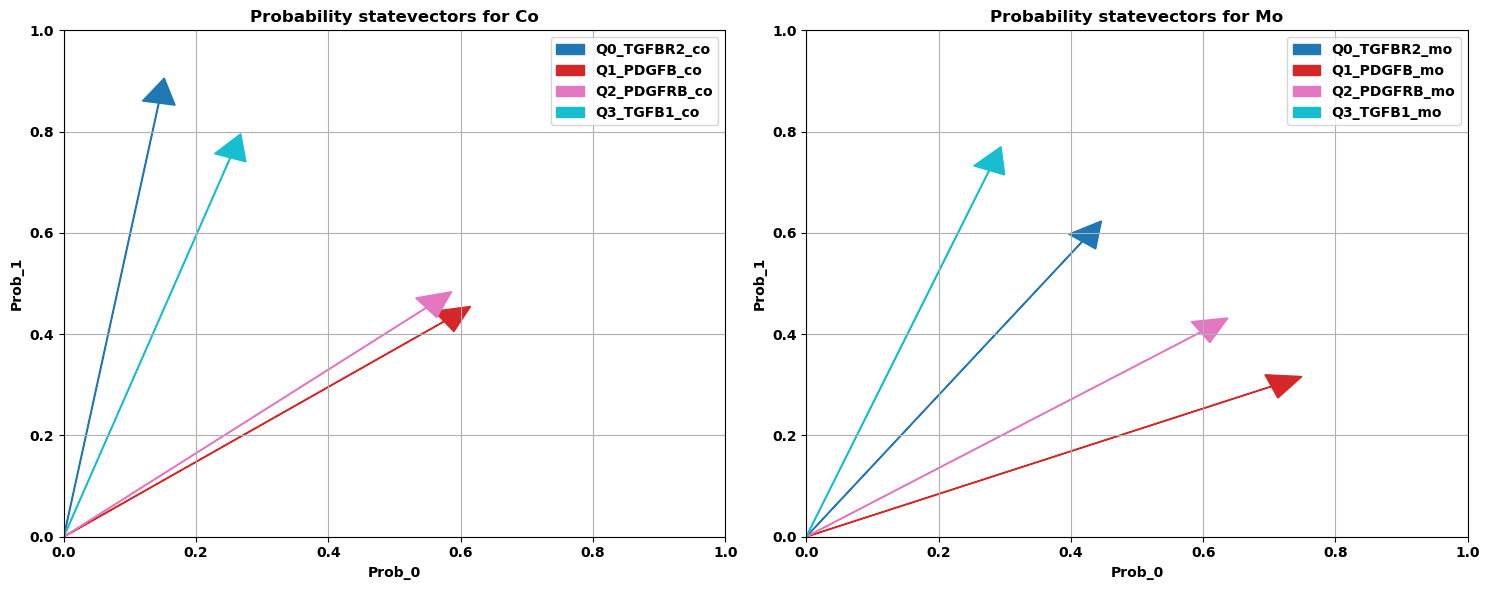

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.exceptions import QiskitError 
from qiskit.quantum_info import DensityMatrix, Statevector, partial_trace

# Assuming bound_qc_co and bound_qc_mo are defined
# Assuming gl_source and gl_recv are defined
bound_qc_co = cc_grn_circuit_co.copy()
bound_qc_co.assign_parameters(all_params_lr_co, inplace=True)
state_co = Statevector(bound_qc_co)

bound_qc_mo = cc_grn_circuit_mo.copy()
bound_qc_mo.assign_parameters(all_params_lr_mo, inplace=True)
state_mo = Statevector(bound_qc_mo)

# Calculate reduced density matrices and probabilities for bound_qc_co
density_matrix_co = DensityMatrix(bound_qc_co)
n_qubits = density_matrix_co.num_qubits

co_data = []
for qubit_to_keep in range(n_qubits):
    trace_out_qubits = list(range(n_qubits))
    trace_out_qubits.pop(qubit_to_keep)
    reduced_density_matrix_data = partial_trace(density_matrix_co, trace_out_qubits).data
    prob_0 = np.real(reduced_density_matrix_data[0, 0])
    prob_1 = np.real(reduced_density_matrix_data[1, 1])
    co_data.append([qubit_to_keep, prob_0, prob_1])

# Calculate reduced density matrices and probabilities for bound_qc_mo
density_matrix_mo = DensityMatrix(bound_qc_mo)
n_qubits = density_matrix_mo.num_qubits

mo_data = []
for qubit_to_keep in range(n_qubits):
    trace_out_qubits = list(range(n_qubits))
    trace_out_qubits.pop(qubit_to_keep)
    reduced_density_matrix_data = partial_trace(density_matrix_mo, trace_out_qubits).data
    prob_0 = np.real(reduced_density_matrix_data[0, 0])
    prob_1 = np.real(reduced_density_matrix_data[1, 1])
    mo_data.append([qubit_to_keep, prob_0, prob_1])

# Create DataFrames
co_df = pd.DataFrame(co_data, columns=['Qubit', 'Prob_0_co', 'Prob_1_co'])
mo_df = pd.DataFrame(mo_data, columns=['Qubit', 'Prob_0_mo', 'Prob_1_mo'])

# Concatenate DataFrames
concatenated_df = pd.concat([co_df.set_index('Qubit'), mo_df.set_index('Qubit')], axis=1)

# Print the concatenated DataFrame
print(concatenated_df)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create two subplots side by side

# Define colors for each qubit using tab20 or tab10
if n_qubits <= 10:
    colors = plt.cm.tab10(np.linspace(0, 1, n_qubits))
else:
    colors = plt.cm.tab20(np.linspace(0, 1, n_qubits))

genes = gl_source + gl_recv  # Concatenate genes

# Plot for co (left subplot)
ax1 = axes[0]
for index, row in co_df.iterrows():
    ax1.arrow(0, 0, row['Prob_0_co'], row['Prob_1_co'],
              head_width=0.05, head_length=0.05, fc=colors[index], ec=colors[index],
              label=f"Q{int(row['Qubit'])}_{genes[index]}_co")  # Corrected

ax1.set_xlabel('Prob_0')
ax1.set_ylabel('Prob_1')
ax1.set_title('Probability statevectors for Co')
ax1.grid(True)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.legend()

# Plot for mo (right subplot)
ax2 = axes[1]
for index, row in mo_df.iterrows():
    ax2.arrow(0, 0, row['Prob_0_mo'], row['Prob_1_mo'],
              head_width=0.05, head_length=0.05, fc=colors[index], ec=colors[index],
              label=f"Q{int(row['Qubit'])}_{genes[index]}_mo")  # Corrected

ax2.set_xlabel('Prob_0')
ax2.set_ylabel('Prob_1')
ax2.set_title('Probability statevectors for Mo')
ax2.grid(True)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.show()